In [1]:
import os

# Specify the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
# Initialize lists to store the pose keypoints and action scores for each phase
import numpy as np
import json
from PIL import Image
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler


from scipy.interpolate import interp1d, CubicSpline
# Initialize lists to store the pose keypoints, action scores, and frames for each phase
pose_keypoints = []
BUaction_scores = []
EXaction_scores = []
FTaction_scores = []
num_frames = []
frames = []  # List to store frames
pose_directory = '/workspace/tevinm/Experiment 2/keypoints/'  # Directory containing JSON files
frame_directory = '/workspace/tevinm/Experiment 2/images/'  # Directory containing frames
action_scores_directory = '/workspace/tevinm/Experiment 2/images/'  # Directory containing action scores

# Process each subdirectory in the action scores directory
for execution_phase in os.listdir(action_scores_directory):
    # Ensure we're looking at a directory
    if os.path.isdir(os.path.join(action_scores_directory, execution_phase)):
        # Get the list of JSON files in the subdirectory
        json_files = os.listdir(os.path.join(pose_directory, execution_phase))

        # Load the action scores for this execution phase
        #BUaction_scores_execution = np.loadtxt(os.path.join(action_scores_directory, execution_phase, 'buildupas.txt'))
        #BUaction_scores_execution = [np.mean(scores) for scores in BUaction_scores_execution]
        EXaction_scores_execution = np.loadtxt(os.path.join(action_scores_directory, execution_phase, 'action_scores.txt'))
        #EXaction_scores_execution = [np.mean(scores) for scores in EXaction_scores_execution]
        #FTaction_scores_execution = np.loadtxt(os.path.join(action_scores_directory, execution_phase, 'followthroughas.txt'))
        #FTaction_scores_execution = [np.mean(scores) for scores in FTaction_scores_execution]
        #average_action_scores = np.mean(action_scores_execution)

        # Initialize a list to store the pose keypoints for this phase
        pose_keypoints_phase = []
        frames_phase = []  # List to store frames for this phase
        old_size = (128, 128)  # Replace with the actual old size
        new_size = (128, 128) #leave this the same we are just changing to test the model to run quicker
        missing_keypoints_indices = []
        # Process each JSON file
        for json_file_index, json_file in enumerate(json_files):
            # Construct the full path to the JSON file
            json_path = os.path.join(pose_directory, execution_phase, json_file)
            Folder_path = os.path.join(pose_directory, execution_phase)
            # Load JSON data
            with open(json_path, 'r') as f:
                data = json.load(f)

            # Extract pose information for all people
            # Extract pose information for all people
            # Check if data is empty
            if not data:
                # If data is empty, search for a frame in the folder that has keypoints
                for filename in os.listdir(Folder_path):
                    if filename.endswith('.json'):
                        with open(os.path.join(Folder_path, filename), 'r') as f:
                            data = json.load(f)
                            if data:
                                # If data is not empty, assign its keypoints to the current frame
                                keypoints = data['0']
                                break
                else:
                    # If no frame with keypoints is found, assign all zeros to keypoints
                    keypoints = [0] * 75
            else:
                keypoints = data['0']

            # Convert keypoints to numpy array for processing
            keypoints = np.array(keypoints)
            keypoints = keypoints.reshape(-1, 3)

            # Apply cubic spline interpolation
            x = np.arange(len(keypoints))
            cs = CubicSpline(x, keypoints)
            #x_new = np.linspace(0, len(keypoints)-1, num=75)  # Change 100 to desired number of keypoints
            #keypoints_interpolated = cs(x_new)

            # Normalize the keypoints to be in the range [0, 1]
            scaler = MinMaxScaler(feature_range=(0, 1))
            keypoints_normalized = scaler.fit_transform(keypoints)
            #keypoints_normalized = scaler.fit_transform(keypoints_interpolated.reshape(-1, 1))

            # Append the normalized keypoints to pose_keypoints_phase
            pose_keypoints_phase.append(keypoints_normalized.tolist())

            # Assuming the frames are .jpg files
            
            frame_path = os.path.join(frame_directory, execution_phase, os.path.splitext(json_file)[0] + '.jpg')
            frame = Image.open(frame_path)
            frame = frame.resize(new_size)

            # Normalize the frame
            frame = np.array(frame) / 255.0

            frames_phase.append(frame)

        

        print(f"Execution phase: {execution_phase}")
        print(f"Number of frames: {len(frames_phase)}")
        print(f"Number of pose keypoints: {len(pose_keypoints_phase)}")
        print(f"Shape of first frame: {frames_phase[0].shape if frames_phase else 'No frames'}")
        print(f"Length of first pose keypoints: {len(pose_keypoints_phase[0]) if pose_keypoints_phase[0] is not None else 'No pose keypoints'}")
        #print(f"Buildup Action scores: {BUaction_scores_execution}")
        #print(f"Buildup Action scores: {EXaction_scores_execution}")
        #print(f"Buildup Action scores: {FTaction_scores_execution}")
        #print(f"Indices of frames with missing keypoints: {missing_keypoints_indices}")

        # Append the pose keypoints, action scores, and frames for this phase to the overall lists
        pose_keypoints.append(pose_keypoints_phase)
        #print(pose_keypoints)
        #BUaction_scores.append(BUaction_scores_execution)
        EXaction_scores.append(EXaction_scores_execution)
        #FTaction_scores.append(FTaction_scores_execution)
        frames.append(frames_phase)

        # Append the number of frames in this phase to the list
        num_frames.append(len(pose_keypoints_phase))

In [3]:
pose_keypoints = np.array(pose_keypoints)
print(f"Shape of pose keypoints array: {pose_keypoints.shape}")
#print(pose_keypoints[100])
frames = np.array(frames)
print(f"Shape of frames array: {frames.shape}")
EXaction_scores = np.array(EXaction_scores)
print(f"Shape of Execution action scores array: {EXaction_scores.shape}")
print(EXaction_scores[100])
print(f"Min and max of keypoints: {np.min(pose_keypoints)}, {np.max(pose_keypoints)}")
print(f"Min and max of frames: {np.min(frames)}, {np.max(frames)}")

Shape of pose keypoints array: (8540, 4, 25, 3)
Shape of frames array: (8540, 4, 128, 128, 3)
Shape of Execution action scores array: (8540, 4, 5)
[[9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]
 [9. 9. 9. 9. 9.]]
Min and max of keypoints: 0.0, 1.0000000000000009
Min and max of frames: 0.0, 1.0


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine the frames, keypoints, and action scores into a single list of tuples
all_data = list(zip(frames, pose_keypoints, EXaction_scores))

# Split the data into training and other sets (validation + test)
train, other = train_test_split(all_data, test_size=0.25, random_state=42)

# Split the other data into validation and test sets
val, test = train_test_split(other, test_size=0.4, random_state=42)  # 0.4 * 0.25 = 0.1

# Unzip the data
X_train_frames, X_train_pose, y_train = zip(*train)
X_test_frames, X_test_pose, y_test = zip(*test)
X_val_frames, X_val_pose, y_val = zip(*val)

# Convert lists to numpy arrays
X_train_frames = np.array(X_train_frames)
X_train_pose = np.array(X_train_pose)
y_train = np.array(y_train)
X_test_frames = np.array(X_test_frames)
X_test_pose = np.array(X_test_pose)
y_test = np.array(y_test)
X_val_frames = np.array(X_val_frames)
X_val_pose = np.array(X_val_pose)
y_val = np.array(y_val)



# Print the shapes of the datasets
print(f"Training set: {X_train_frames.shape}, {X_train_pose.shape}, {y_train.shape}")
print(f"Validation set: {X_val_frames.shape}, {X_val_pose.shape}, {y_val.shape}")
print(f"Testing set: {X_test_frames.shape}, {X_test_pose.shape}, {y_test.shape}")

print(f"Min and max of keypoints: {np.min(X_train_pose)}, {np.max(X_train_pose)}")
print(f"Min and max of frames: {np.min(X_train_frames)}, {np.max(X_train_frames)}")

Training set: (6405, 4, 128, 128, 3), (6405, 4, 25, 3), (6405, 4, 5)
Validation set: (1281, 4, 128, 128, 3), (1281, 4, 25, 3), (1281, 4, 5)
Testing set: (854, 4, 128, 128, 3), (854, 4, 25, 3), (854, 4, 5)
Min and max of keypoints: 0.0, 1.0000000000000009
Min and max of frames: 0.0, 1.0


In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Dense,  Flatten, Reshape, Dropout, RepeatVector, LSTM, TimeDistributed
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
import tensorflow as tf
from i3d_inception import Inception_Inflated3d
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



i3d_model = Inception_Inflated3d(include_top=False, weights='rgb_imagenet_and_kinetics', input_shape=(4, 128, 128, 3))
# Set the I3D model to be non-trainable
i3d_model.trainable = False


# Set TensorFlow device to CPU
with tf.device('/GPU:0'):
    # Define the encoder
    input_frames = Input(shape=(4, 128, 128, 3))
    x = i3d_model(input_frames)
    encoded_frames = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same', name='pool3')(x)

    # Define the decoder
    x = Conv3D(1024, (3, 3, 3), activation='relu', padding='same', name='conv4')(encoded_frames)
    x = UpSampling3D((1, 2, 2))(x)
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5')(x)
    x = UpSampling3D((1, 2, 2))(x)
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv6')(x)
    x = UpSampling3D((1, 2, 2))(x)
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv7')(x)
    x = UpSampling3D((1, 2, 2))(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv8')(x)
    x = UpSampling3D((1, 2, 2))(x)
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv9')(x)
    x = UpSampling3D((1, 2, 2))(x)
    decoded_frames = Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same', name='conv10')(x)
    
    # Define the encoder part of the autoencoder for the pose data
    input_pose = Input(shape=(4, 25, 3))
    x = Flatten()(input_pose)
    x = Reshape((4, 25*3))(x)
    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(128)(x)
    x = Dropout(0.2)(x)
    encoded_pose = Dense(32, activation='relu')(x)

    # Define the decoder part of the autoencoder for the pose data
    x = RepeatVector(4)(encoded_pose)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(256, return_sequences=True)(x)
    decoded_pose = TimeDistributed(Dense(25*3, activation='sigmoid'))(x)
    decoded_pose = Reshape((4, 25, 3))(decoded_pose)
    
    optimizer = SGD(learning_rate=0.01)

    # Define the autoencoder model
    autoencoder = Model([input_frames, input_pose], [decoded_frames, decoded_pose])
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    autoencoder.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Define the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint('E3T1.h5', monitor='val_loss', save_best_only=True)

    # Train the autoencoder
    history = autoencoder.fit([X_train_frames, X_train_pose], [X_train_frames, X_train_pose], epochs=100, batch_size=32, validation_data=([X_val_frames, X_val_pose], [X_val_frames, X_val_pose]), callbacks=[early_stopping, model_checkpoint])



2024-05-23 14:25:22.448029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 14:25:22.448075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 14:25:22.448093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 14:25:22.453145: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 14:25:34.555379: I tensor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4, 128, 128, 3)]     0         []                            
                                                                                                  
 i3d_inception (Functional)  (None, 4, 4, 4, 1024)        1229454   ['input_2[0][0]']             
                                                          4                                       
                                                                                                  
 pool3 (MaxPooling3D)        (None, 4, 2, 2, 1024)        0         ['i3d_inception[0][0]']       
                                                                                                  
 input_3 (InputLayer)        [(None, 4, 25, 3)]           0         []                        

2024-05-23 14:25:58.191506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-23 14:25:59.678644: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5583655464c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 14:25:59.678677: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-23 14:25:59.749149: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 [==============================] - ETA: 0s - loss: 0.1296 - conv10_loss: 0.0232 - reshape_2_loss: 0.1064 - conv10_mse: 0.0232 - reshape_2_mse: 0.1064

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/201 [==============================] - 34s 121ms/step - loss: 0.1296 - conv10_loss: 0.0232 - reshape_2_loss: 0.1064 - conv10_mse: 0.0232 - reshape_2_mse: 0.1064 - val_loss: 0.1273 - val_conv10_loss: 0.0215 - val_reshape_2_loss: 0.1058 - val_conv10_mse: 0.0215 - val_reshape_2_mse: 0.1058
Epoch 2/100
201/201 [==============================] - 17s 86ms/step - loss: 0.1266 - conv10_loss: 0.0208 - reshape_2_loss: 0.1059 - conv10_mse: 0.0208 - reshape_2_mse: 0.1059 - val_loss: 0.1259 - val_conv10_loss: 0.0206 - val_reshape_2_loss: 0.1053 - val_conv10_mse: 0.0206 - val_reshape_2_mse: 0.1053
Epoch 3/100
201/201 [==============================] - 17s 86ms/step - loss: 0.1254 - conv10_loss: 0.0201 - reshape_2_loss: 0.1053 - conv10_mse: 0.0201 - reshape_2_mse: 0.1053 - val_loss: 0.1248 - val_conv10_loss: 0.0200 - val_reshape_2_loss: 0.1048 - val_conv10_mse: 0.0200 - val_reshape_2_mse: 0.1048
Epoch 4/100
201/201 [==============================] - 18s 88ms/step - loss: 0.1245 - conv10_loss: 0.0

In [18]:
from keras.layers import LSTM, TimeDistributed, Dense, Dropout, Input, Concatenate
from keras.models import Model

import tensorflow as tf

with tf.device('/GPU:3'):
    # Use the encoder to transform the input data into encoded representations
    y_train2 = y_train.mean(axis=1)
    y_val2 = y_val.mean(axis=1)
    encoder = Model([input_frames, input_pose], [encoded_frames, encoded_pose])
    encoder.load_weights('E3T1.h5', by_name=True)
    x_train_encoded_frames, x_train_encoded_pose = encoder.predict([X_train_frames, X_train_pose])
    x_val_encoded_frames, x_val_encoded_pose = encoder.predict([X_val_frames, X_val_pose])

    # Reshape the encoded frames and pose for regression
    x_train_encoded_frames_flattened = x_train_encoded_frames.reshape(x_train_encoded_frames.shape[0], x_train_encoded_frames.shape[1], -1)
    x_val_encoded_frames_flattened = x_val_encoded_frames.reshape(x_val_encoded_frames.shape[0], x_val_encoded_frames.shape[1], -1)
    x_train_encoded_pose_flattened = x_train_encoded_pose.reshape(x_train_encoded_pose.shape[0], -1)
    x_val_encoded_pose_flattened = x_val_encoded_pose.reshape(x_val_encoded_pose.shape[0], -1)


    # Define the aggregation model
    input_encoded_frames = Input(shape=(x_train_encoded_frames_flattened.shape[1], x_train_encoded_frames_flattened.shape[2]))
    input_encoded_pose = Input(shape=(x_train_encoded_pose_flattened.shape[1],))
    x = LSTM(32)(input_encoded_frames) #consider increasing to 128
    x = Dropout(0.2)(x)
    
    # Define the aggregation model
    y = Dense(256, activation='relu')(input_encoded_pose)
    y = Dropout(0.2)(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(64, activation='relu')(y)
    y = Dropout(0.2)(y)
    y = Dense(32, activation='relu')(y)
    
    # regression part
    z = Concatenate()([x, y])
    output_scores = Dense(5, activation='linear')(z)

    # Define the model
    regression_model = Model([input_encoded_frames, input_encoded_pose], output_scores)

    optimizer = Adam(learning_rate=0.0001)

    # Compile the model
    regression_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # Define the ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint('E3T2R.h5', monitor='val_loss', save_best_only=True)

    history = regression_model.fit([x_train_encoded_frames_flattened, x_train_encoded_pose_flattened], y_train2, 
                                        epochs=100, batch_size=32, validation_data=([x_val_encoded_frames_flattened, x_val_encoded_pose_flattened],y_val2) ,shuffle=False, 
                                        callbacks=[early_stopping, model_checkpoint])

        # Train the model
        #history = regression_model.fit([x_train_encoded_frames_flattened, x_train_encoded_pose_flattened], y_train2, epochs=150, batch_size=32, shuffle=True)

41/41 [==============================] - 1s 14ms/step
Epoch 1/100
201/201 [==============================] - 4s 11ms/step - loss: 3.6056 - mae: 3.6056 - val_loss: 2.2721 - val_mae: 2.2721
Epoch 2/100
201/201 [==============================] - 2s 8ms/step - loss: 2.1955 - mae: 2.1955 - val_loss: 2.0981 - val_mae: 2.0981
Epoch 3/100
201/201 [==============================] - 2s 8ms/step - loss: 2.1622 - mae: 2.1622 - val_loss: 2.0894 - val_mae: 2.0894
Epoch 4/100
201/201 [==============================] - 2s 8ms/step - loss: 2.1420 - mae: 2.1420 - val_loss: 2.0823 - val_mae: 2.0823
Epoch 5/100
201/201 [==============================] - 1s 7ms/step - loss: 2.1348 - mae: 2.1348 - val_loss: 2.0689 - val_mae: 2.0689
Epoch 6/100
201/201 [==============================] - 2s 7ms/step - loss: 2.1078 - mae: 2.1078 - val_loss: 2.0532 - val_mae: 2.0532
Epoch 7/100
201/201 [==============================] - 2s 8ms/step - loss: 2.1025 - mae: 2.1025 - val_loss: 2.0436 - val_mae: 2.0436
Epoch 8/100
20

In [8]:
print(y_train2[1])
print(y_train2.shape)
print(y_train[1])
print(y_train.shape)

[9. 8. 9. 7. 7.]
(6405, 5)
[[9. 8. 9. 7. 7.]
 [9. 8. 9. 7. 7.]
 [9. 8. 9. 7. 7.]
 [9. 8. 9. 7. 7.]]
(6405, 4, 5)


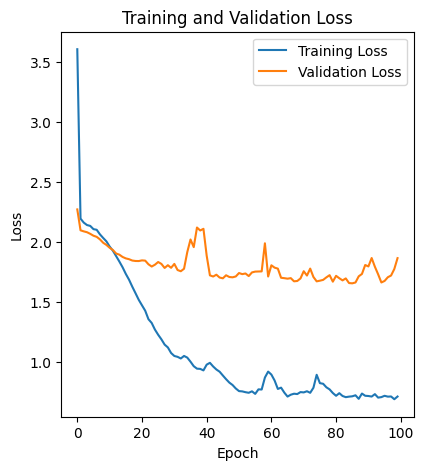

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [25]:
from scipy.stats import spearmanr
import numpy as np


regression_model.load_weights('E3T2R.h5', by_name=True)
encoder.load_weights('E3T1.h5', by_name=True)
# Generate predictions for the test data
encoded_frames_test, encoded_pose_test = encoder.predict([X_test_frames, X_test_pose])
#y_pred = regression_model.predict([encoded_frames_test, encoded_pose_test])
encoded_frames_test_flattened = encoded_frames_test.reshape(encoded_frames_test.shape[0], encoded_frames_test.shape[1], -1)
encoded_pose_test_flattened = encoded_pose_test.reshape(encoded_pose_test.shape[0], -1)
y_pred = regression_model.predict([encoded_frames_test_flattened, encoded_pose_test_flattened])
print(y_pred[:10])
print(y_test[:10])
# Compute the Spearman rank correlation for each output dimension
spearman_scores = [spearmanr(y_test[:, :,i], y_pred[:, i])[0] for i in range(min(y_test.shape[2], y_pred.shape[1]))]

# Compute the average Spearman rank correlation
average_spearman_score = np.mean(spearman_scores)

print('Average Spearman Rank Correlation Score:', average_spearman_score)

27/27 [==============================] - 0s 3ms/step
[[4.7954116 4.0268784 4.535683  4.1392145 4.4528837]
 [6.030835  5.364427  5.451142  5.33992   5.541487 ]
 [8.929447  8.397909  8.686018  8.48851   8.674639 ]
 [4.0736165 3.1900966 3.850864  3.177436  3.6857502]
 [7.364315  6.678688  6.9956703 6.5550385 6.721264 ]
 [2.5506256 1.9061399 2.3093612 1.8944726 2.2427137]
 [6.7419233 6.131466  6.083371  6.0026813 6.0519915]
 [6.9745545 6.3537073 6.526499  6.806213  6.635892 ]
 [4.0172405 3.1293573 3.5625572 3.3781264 3.7647848]
 [7.9278693 7.6346793 7.744418  7.8054485 7.5386524]]
[[[7. 7. 6. 7. 6.]
  [7. 7. 6. 7. 6.]
  [7. 7. 6. 7. 6.]
  [7. 7. 6. 7. 6.]]

 [[9. 8. 9. 8. 9.]
  [9. 8. 9. 8. 9.]
  [9. 8. 9. 8. 9.]
  [9. 8. 9. 8. 9.]]

 [[9. 8. 8. 9. 8.]
  [9. 8. 8. 9. 8.]
  [9. 8. 8. 9. 8.]
  [9. 8. 8. 9. 8.]]

 [[7. 6. 7. 6. 7.]
  [7. 6. 7. 6. 7.]
  [7. 6. 7. 6. 7.]
  [7. 6. 7. 6. 7.]]

 [[2. 1. 2. 1. 2.]
  [2. 1. 2. 1. 2.]
  [2. 1. 2. 1. 2.]
  [2. 1. 2. 1. 2.]]

 [[2. 1. 2. 1. 2.]
  [2. 1

In [26]:
from scipy.stats import spearmanr
import numpy as np

body_parts = ['part1', 'part2', 'part3', 'part4', 'part5']  # replace with your actual body part names

# Calculate SRC for each body part
spearman_scores = [spearmanr(y_test[:, :, i], y_pred[:, i])[0] for i in range(min(y_test.shape[2], y_pred.shape[1]))]

# Calculate the average SRC for each body part
average_spearman_scores = [np.mean(score) for score in spearman_scores]

for i, part in enumerate(body_parts):
    # Print average SRC
    print(f'Average Spearman Rank Correlation for {part}:', average_spearman_scores[i])

Average Spearman Rank Correlation for part1: 0.8414655306297394
Average Spearman Rank Correlation for part2: 0.8404071082489311
Average Spearman Rank Correlation for part3: 0.8386582877119346
Average Spearman Rank Correlation for part4: 0.8402711665255154
Average Spearman Rank Correlation for part5: 0.8384401156672995


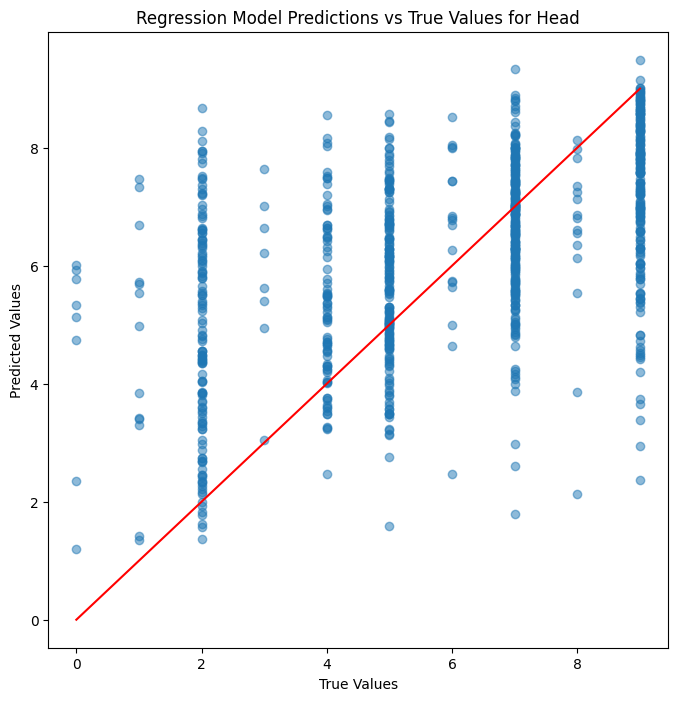

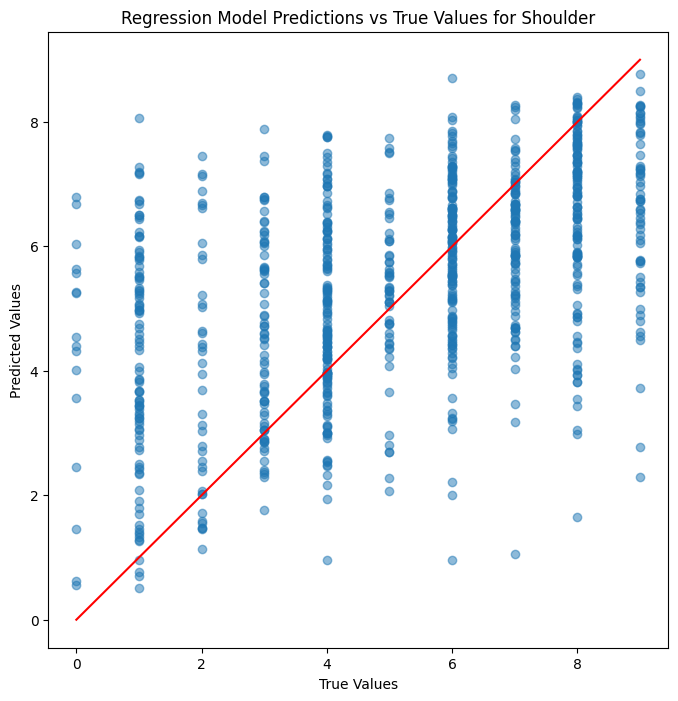

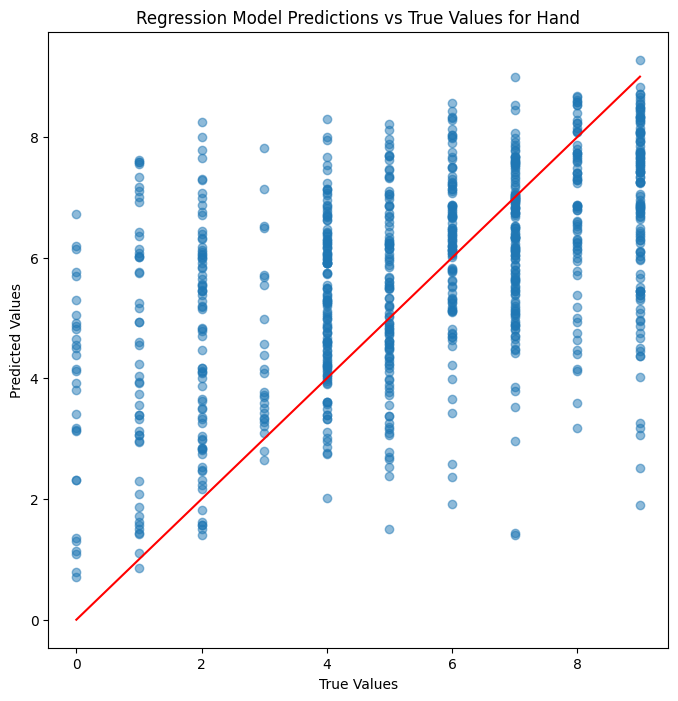

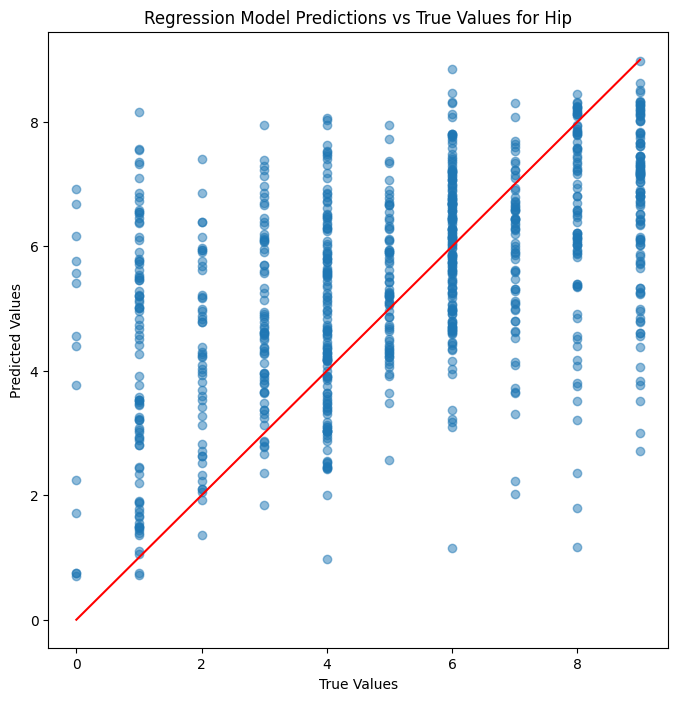

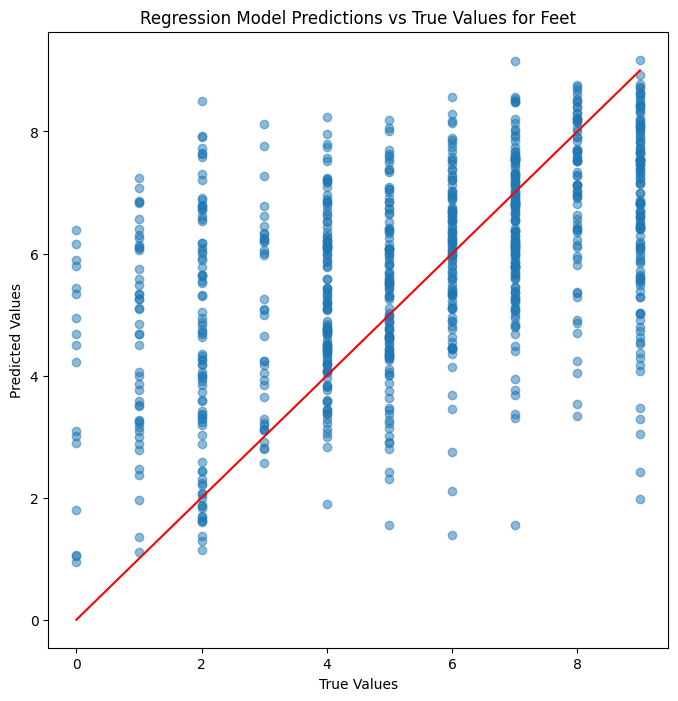

In [28]:
body_parts = ['Head', 'Shoulder', 'Hand', 'Hip', 'Feet']  # replace with your actual body part names
y_test2 = y_test.mean(axis=1)

for i, part in enumerate(body_parts):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test2[:, i], y_pred[:, i], alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Regression Model Predictions vs True Values for {part}')
    plt.plot([np.min(y_test[:, :,i]), np.max(y_test[:, :, i])], [np.min(y_test[:, :,i]), np.max(y_test[:, :,i])], color='red')
    #plt.savefig(f'plot{i}.png')
    plt.show()

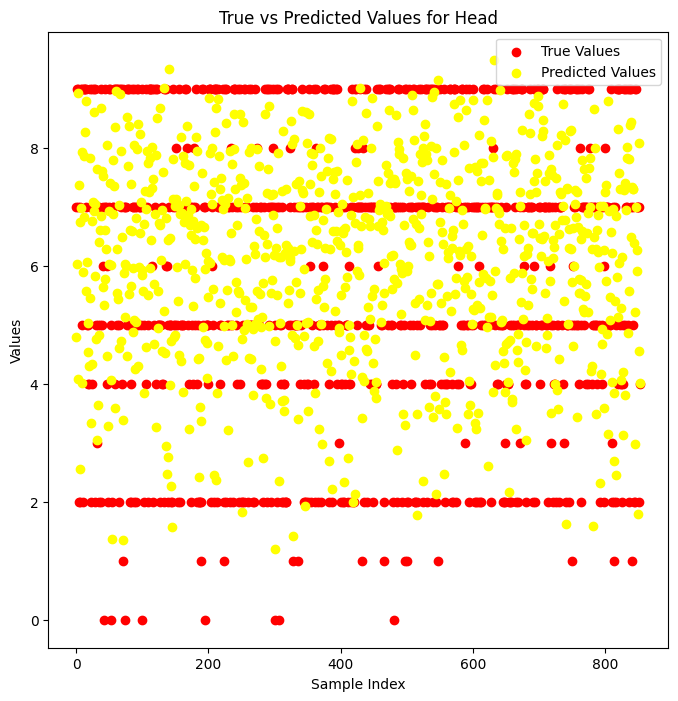

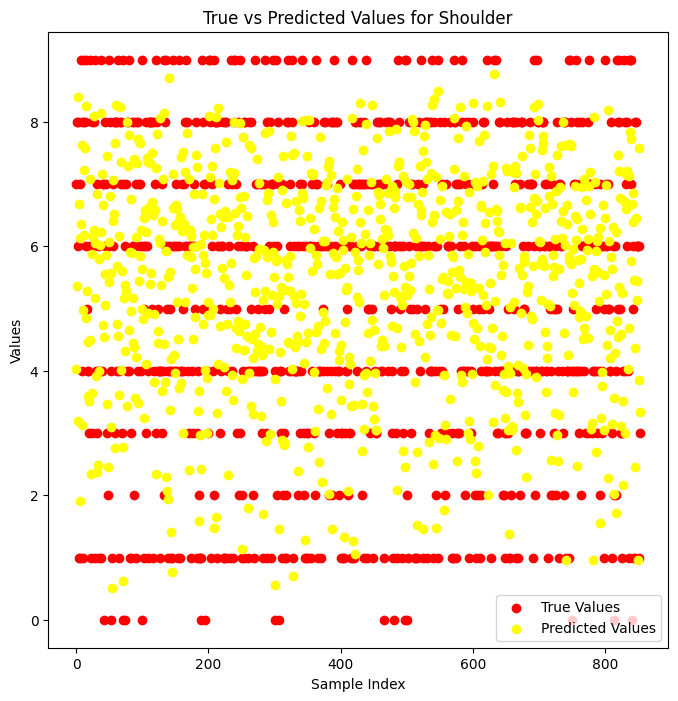

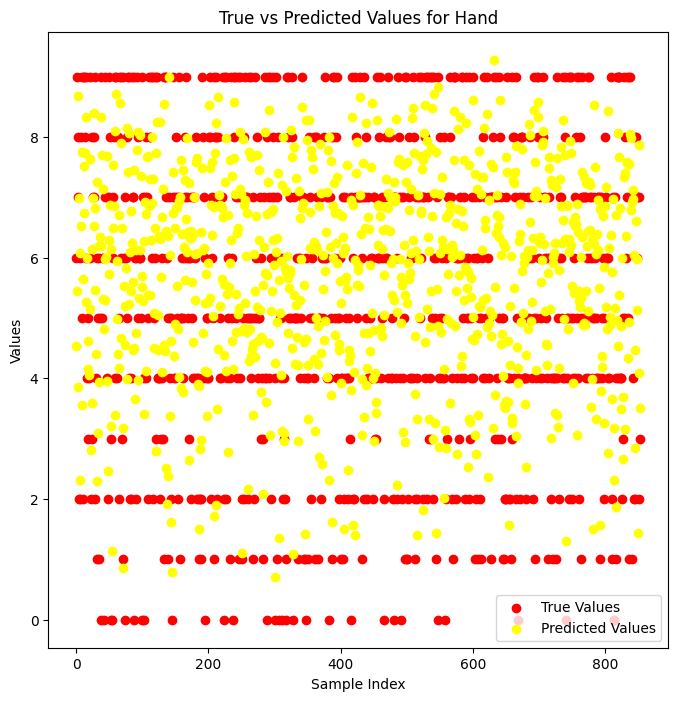

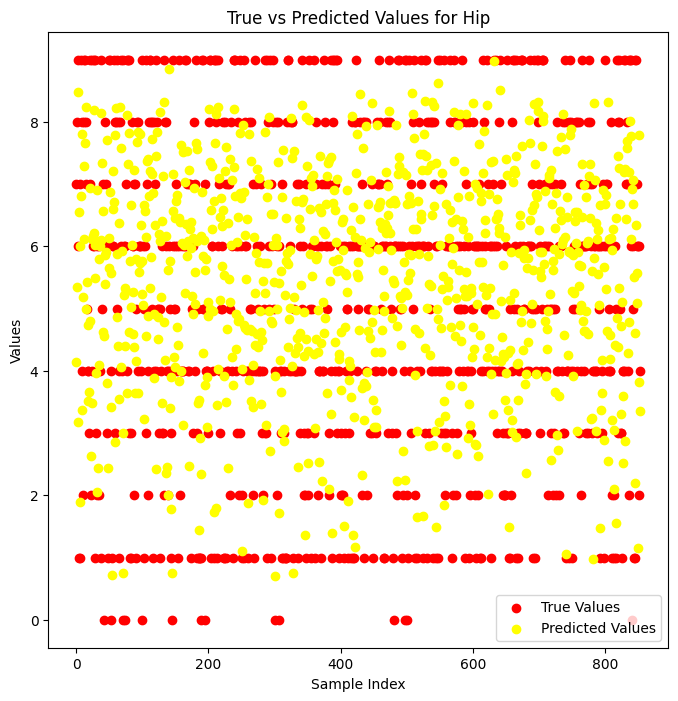

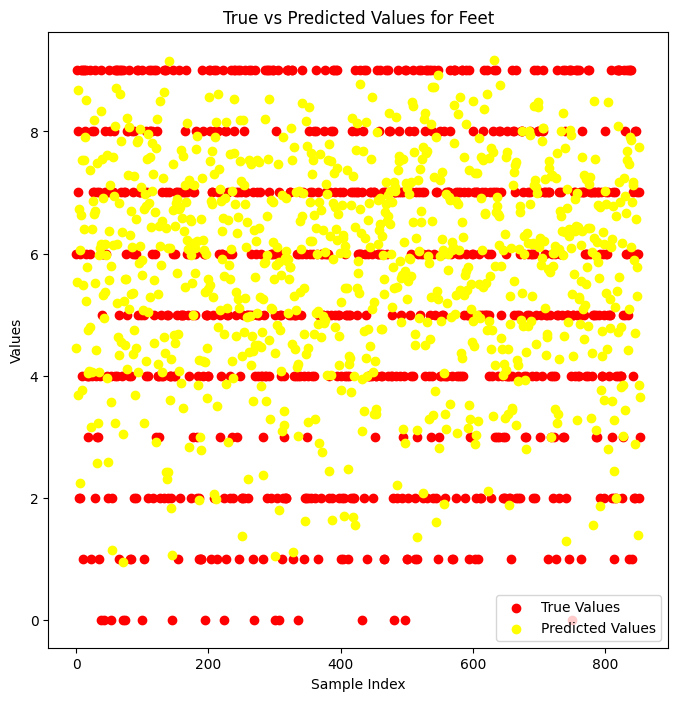

In [29]:
for i, part in enumerate(body_parts):
    plt.figure(figsize=(8, 8))
    plt.scatter(range(len(y_test2[:, i])), y_test2[:, i], color='red', label='True Values')
    plt.scatter(range(len(y_pred[:, i])), y_pred[:, i], color='yellow', label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title(f'True vs Predicted Values for {part}')
    plt.legend()
    #plt.savefig(f'TVA{i}.png')
    plt.show()

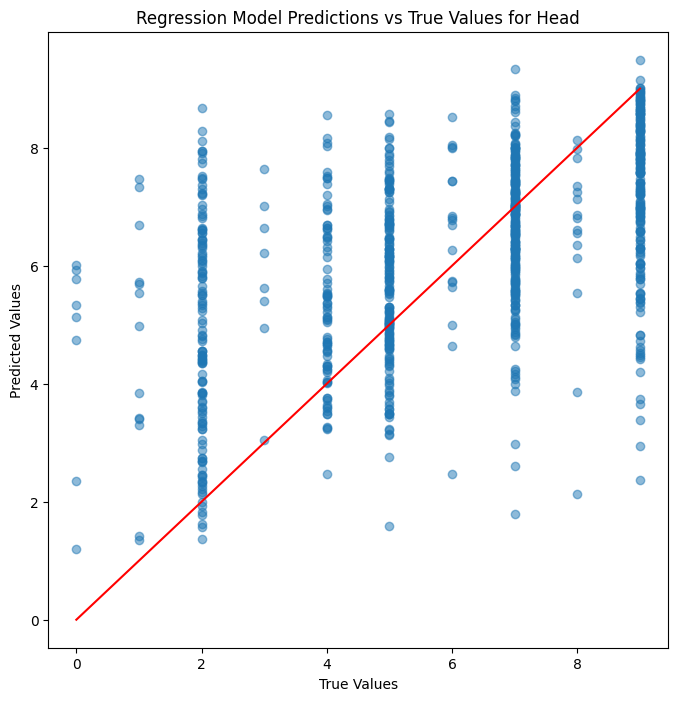

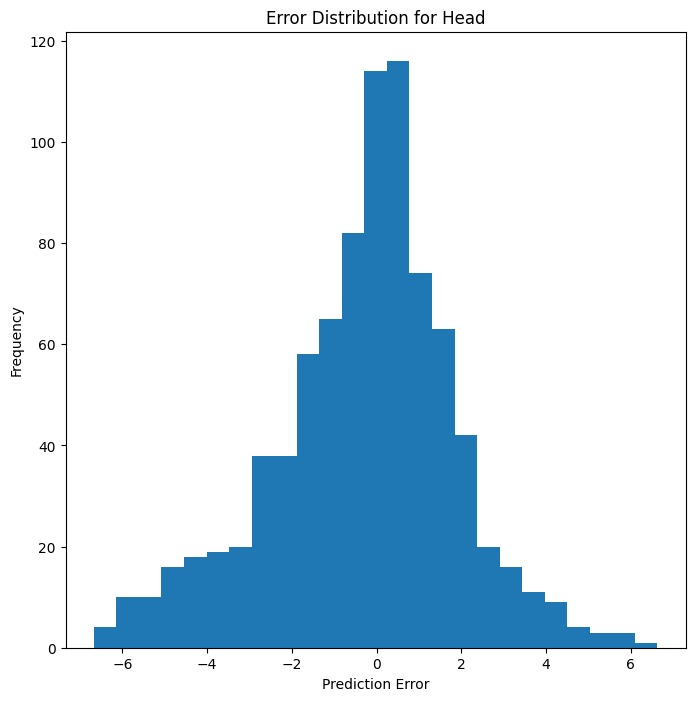

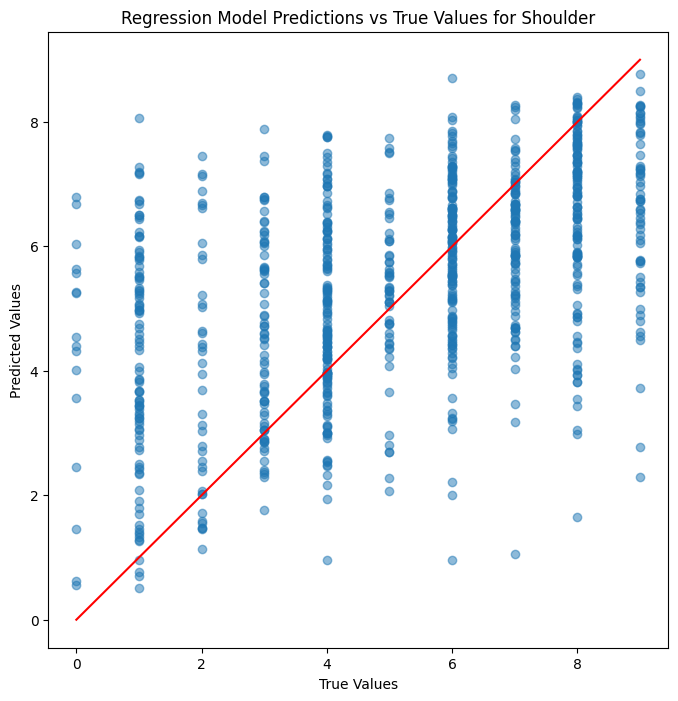

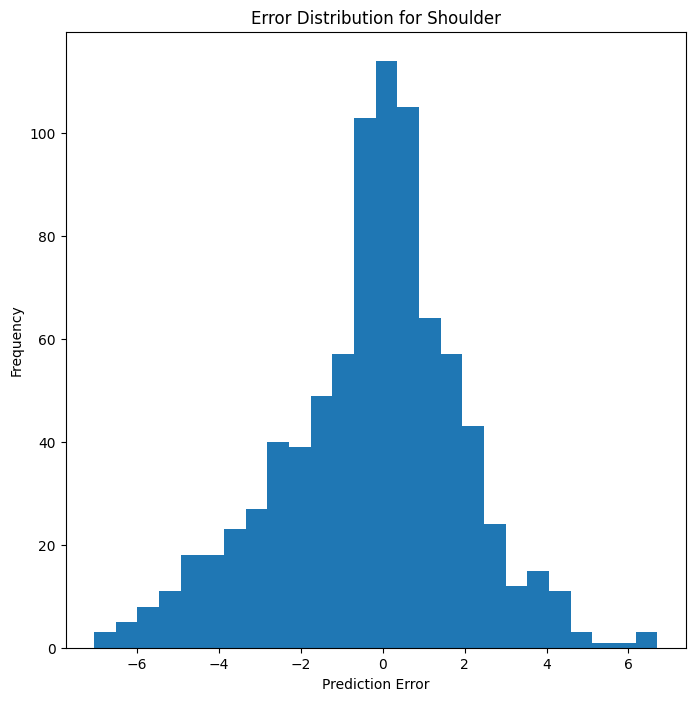

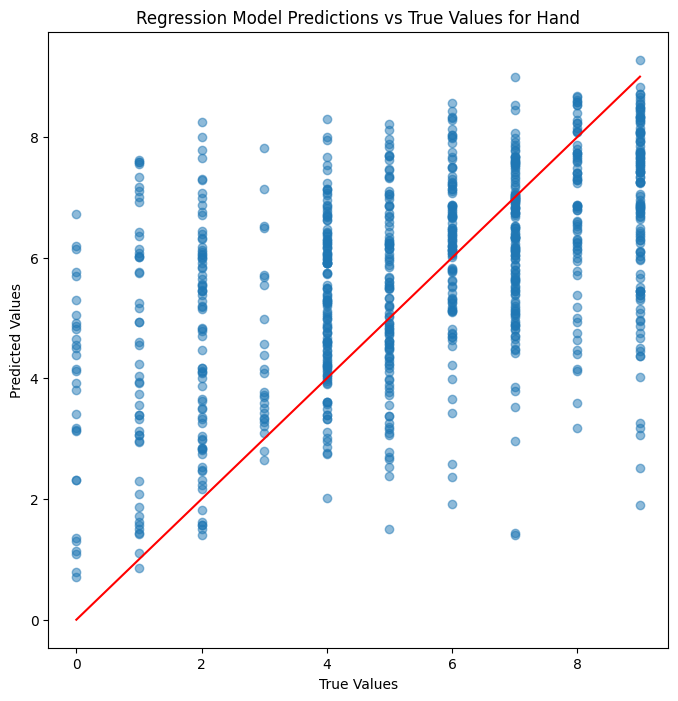

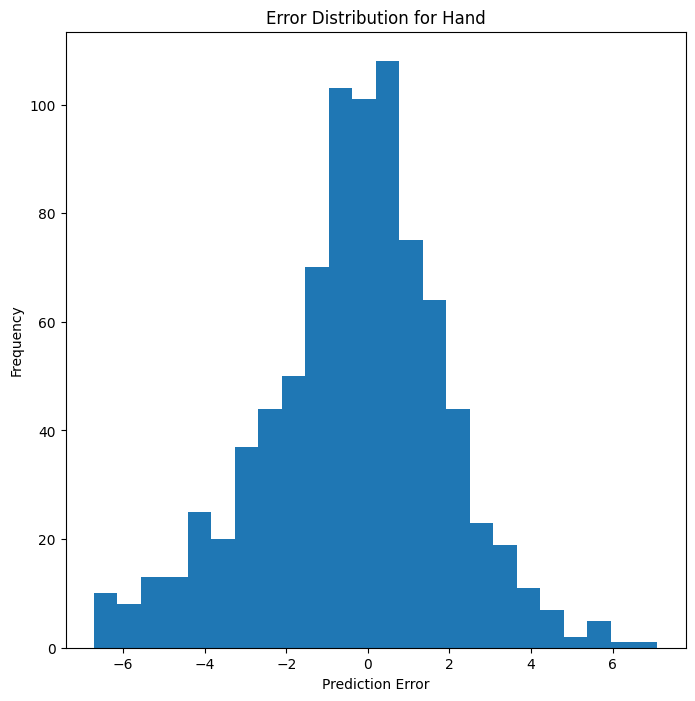

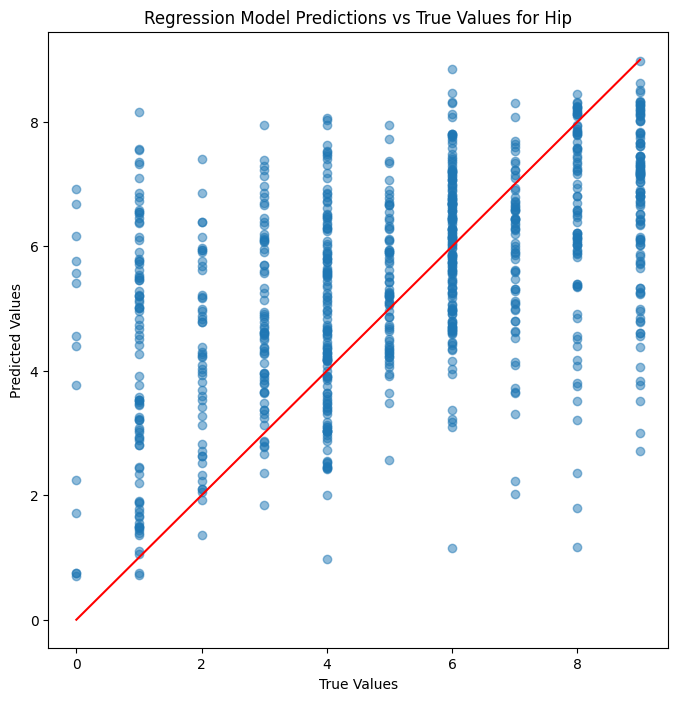

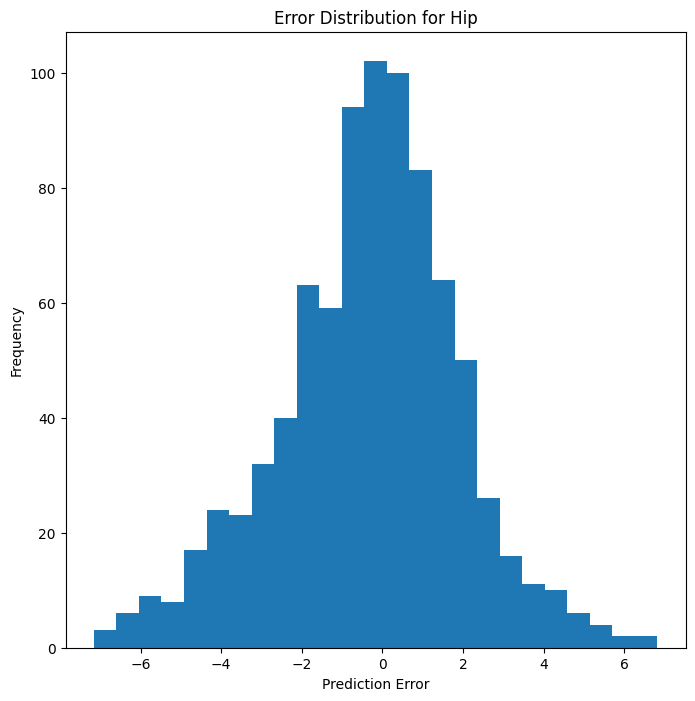

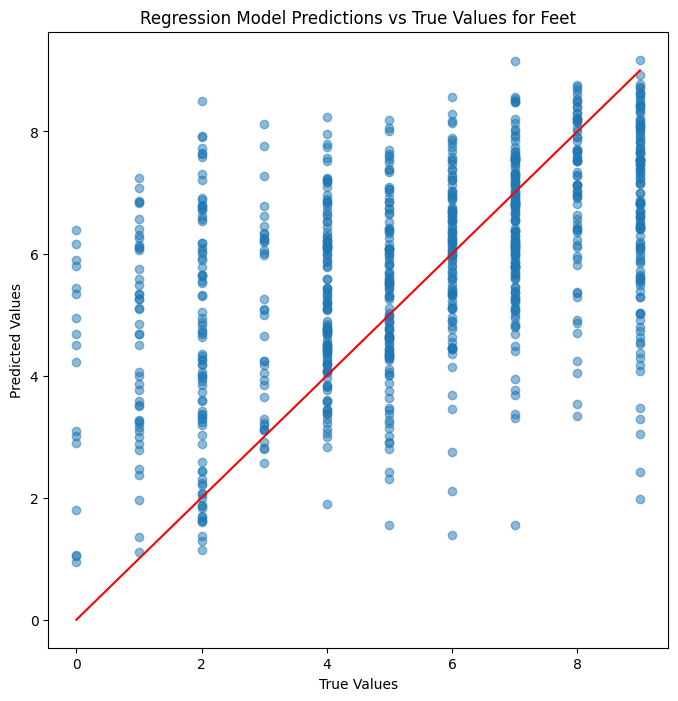

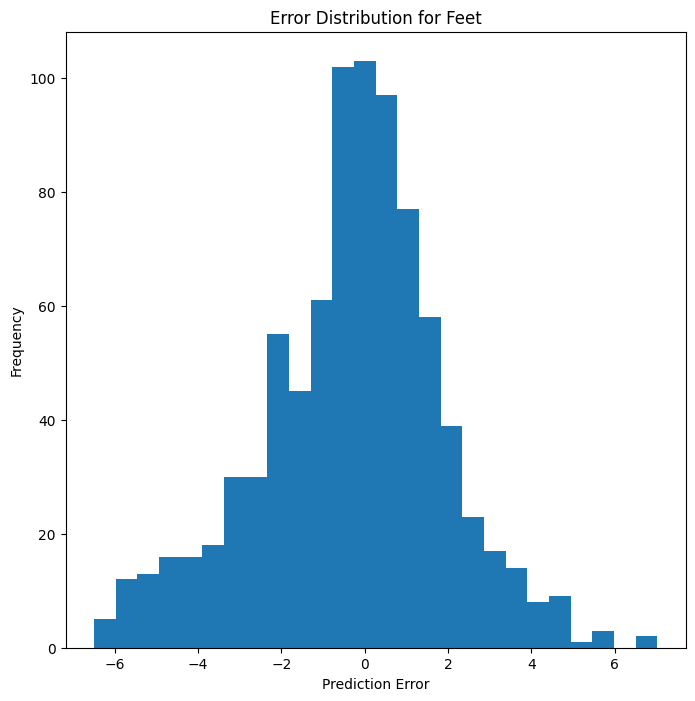

In [30]:
import matplotlib.pyplot as plt
import numpy as np

body_parts = ['Head', 'Shoulder', 'Hand', 'Hip', 'Feet']  # replace with your actual body part names
y_test2 = y_test.mean(axis=1)

for i, part in enumerate(body_parts):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test2[:, i], y_pred[:, i], alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Regression Model Predictions vs True Values for {part}')
    plt.plot([np.min(y_test[:, :,i]), np.max(y_test[:, :, i])], [np.min(y_test[:, :,i]), np.max(y_test[:, :,i])], color='red')

    # Calculate errors
    errors = y_test2[:, i] - y_pred[:, i]

    # Create a histogram of errors
    plt.figure(figsize=(8, 8))
    plt.hist(errors, bins='auto')
    plt.title(f'Error Distribution for {part}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')

    plt.savefig(f'plot{i}.png')
    plt.show()

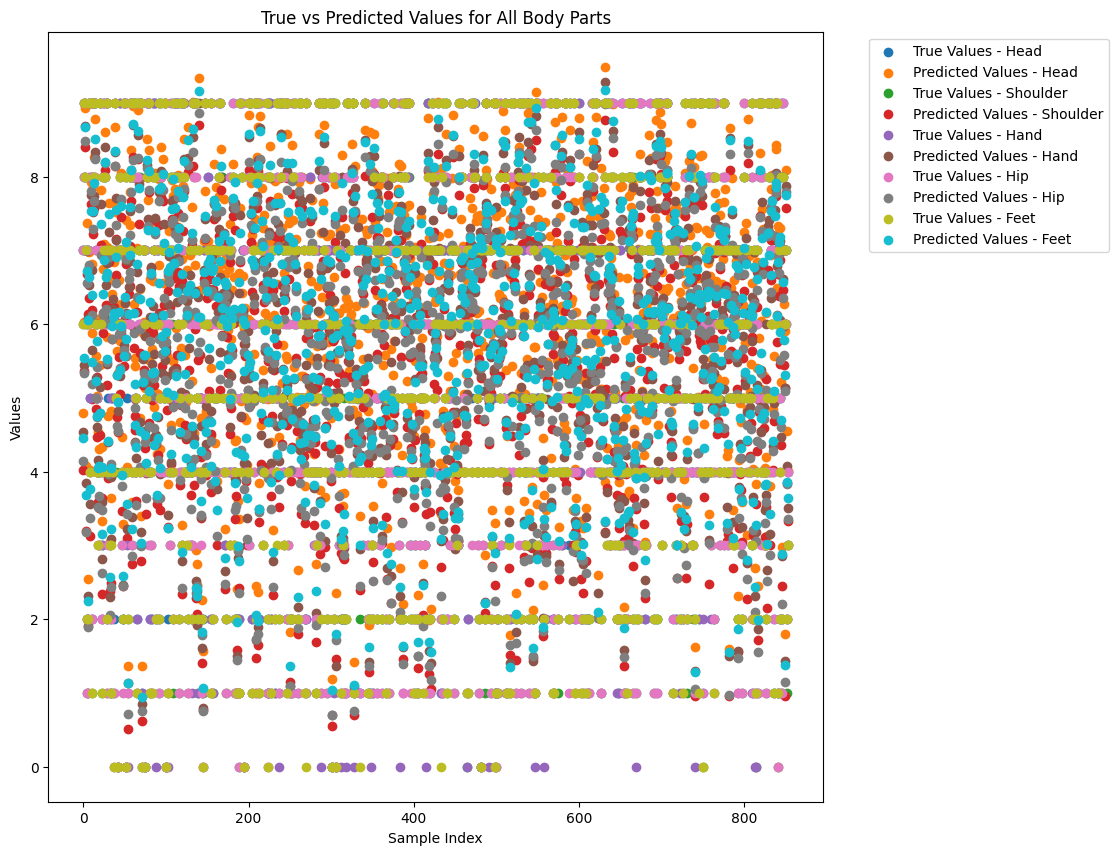

In [33]:
plt.figure(figsize=(10, 10))

# For each body part
for i, part in enumerate(body_parts):
    # Plot the true values
    plt.scatter(range(len(y_test2[:, i])), y_test2[:, i], label=f'True Values - {part}')
    # Plot the predicted values
    plt.scatter(range(len(y_pred[:, i])), y_pred[:, i], label=f'Predicted Values - {part}')

plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True vs Predicted Values for All Body Parts')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside of plot for readability

# Save the figure with a bounding box that includes the legend
plt.savefig('TVA_All.png', bbox_inches='tight')

plt.show()